In [1]:
%reload_ext autoreload
%autoreload 2

import os
import logging
import multiprocessing

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import arviz as az
import jax
import jax.numpy as jnp
import numpyro

from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
# import numpyro.distributions as dist
# from hbmep.model import BaseModel

# class MixedEffects(BaseModel):
#     Name = "mixed_effects_injury_threshold_comparison"

#     def __init__(self, config: Config):
#         super(MixedEffects, self).__init__(config=config)
#         self.combination_columns = self.features + [self.subject]

#     def fn(self, x, a, b, v, L, l, H):
#         return (
#             L
#             + jnp.where(
#                 jnp.less(x, a),
#                 0.,
#                 -l + jnp.true_divide(
#                     H + l,
#                     jnp.power(
#                         1
#                         + jnp.multiply(
#                             -1
#                             + jnp.power(
#                                 jnp.true_divide(H + l, l),
#                                 v
#                             ),
#                             jnp.exp(jnp.multiply(-b, x - a))
#                         ),
#                         jnp.true_divide(1, v)
#                     )
#                 )
#             )
#         )

#     def _model(self, subject, features, intensity, response_obs=None):
#         if response_obs is not None: response_obs = response_obs.flatten(order="F")

#         subject, n_subject = subject
#         features, n_features = features
#         intensity, n_data = intensity

#         intensity = intensity.reshape(-1, 1)
#         intensity = np.tile(intensity, (1, self.n_response))

#         feature0 = features[0].reshape(-1,)
#         n_feature0 = n_features[0]
#         n_baseline = 1

#         mask = np.full((n_subject, n_feature0, self.n_response), True)
#         if response_obs is not None:
#             mask = np.full((n_subject, n_feature0, self.n_response), False)
#             combinations = list(set(zip(subject.tolist(), feature0.tolist())))
#             for c in combinations:
#                 mask[*c, :] = True

#         """ Fixed Effect (Baseline) """
#         with numpyro.plate(site.n_response, self.n_response, dim=-1):
#             with numpyro.plate("n_baseline", n_baseline, dim=-2):
#                 a_mean_baseline = numpyro.sample("a_mean_baseline", dist.HalfNormal(scale=50))

#         """ Random Effect (Delta) """
#         a_mean_delta_global_loc = numpyro.sample("a_mean_delta_global_loc", dist.Normal(loc=0, scale=100))
#         a_mean_delta_global_scale = numpyro.sample("a_mean_delta_global_scale", dist.HalfNormal(100))
#         a_mean_delta_global_df_minus_one = numpyro.sample("a_mean_delta_global_df_minus_one", dist.Exponential(1 / 29.))

#         with numpyro.plate(site.n_response, self.n_response, dim=-1):
#             with numpyro.plate("n_delta", (n_feature0 - n_baseline), dim=-2):
#                 a_mean_delta = numpyro.sample(
#                     "a_mean_delta",
#                     dist.StudentT(
#                         loc=a_mean_delta_global_loc,
#                         scale=a_mean_delta_global_scale,
#                         df=a_mean_delta_global_df_minus_one + 1
#                     )
#                 )

#         with numpyro.plate(site.n_response, self.n_response, dim=-1):
#             """ Global Priors """
#             b_scale_global_scale = numpyro.sample("b_scale_global_scale", dist.HalfNormal(100))
#             v_scale_global_scale = numpyro.sample("v_scale_global_scale", dist.HalfNormal(100))

#             L_scale_global_scale = numpyro.sample("L_scale_global_scale", dist.HalfNormal(1))
#             l_scale_global_scale = numpyro.sample("l_scale_global_scale", dist.HalfNormal(100))
#             H_scale_global_scale = numpyro.sample("H_scale_global_scale", dist.HalfNormal(5))

#             g_1_scale_global_scale = numpyro.sample("g_1_scale_global_scale", dist.HalfNormal(100))
#             g_2_scale_global_scale = numpyro.sample("g_2_scale_global_scale", dist.HalfNormal(100))

#             a_shape = numpyro.sample("a_shape", dist.HalfNormal(scale=100))

#             with numpyro.plate("n_feature0", n_feature0, dim=-2):
#                 """ Hyper-priors """
#                 a_mean = numpyro.deterministic(
#                     "a_mean",
#                     jnp.concatenate([a_mean_baseline, a_mean_baseline + a_mean_delta], axis=0)
#                 )

#                 b_scale_raw = numpyro.sample("b_scale_raw", dist.HalfNormal(scale=1))
#                 b_scale = numpyro.deterministic("b_scale", jnp.multiply(b_scale_global_scale, b_scale_raw))

#                 v_scale_raw = numpyro.sample("v_scale_raw", dist.HalfNormal(scale=1))
#                 v_scale = numpyro.deterministic("v_scale", jnp.multiply(v_scale_global_scale, v_scale_raw))

#                 L_scale_raw = numpyro.sample("L_scale_raw", dist.HalfNormal(scale=1))
#                 L_scale = numpyro.deterministic("L_scale", jnp.multiply(L_scale_global_scale, L_scale_raw))

#                 l_scale_raw = numpyro.sample("l_scale_raw", dist.HalfNormal(scale=1))
#                 l_scale = numpyro.deterministic("sigma_l", jnp.multiply(l_scale_global_scale, l_scale_raw))

#                 H_scale_raw = numpyro.sample("H_scale_raw", dist.HalfNormal(scale=1))
#                 H_scale = numpyro.deterministic("H_scale", jnp.multiply(H_scale_global_scale, H_scale_raw))

#                 g_1_scale_raw = numpyro.sample("g_1_scale_raw", dist.HalfNormal(scale=1))
#                 g_1_scale = numpyro.deterministic("g_1_scale", jnp.multiply(g_1_scale_global_scale, g_1_scale_raw))

#                 g_2_scale_raw = numpyro.sample("g_2_scale_raw", dist.HalfNormal(scale=1))
#                 g_2_scale = numpyro.deterministic("g_2_scale", jnp.multiply(g_2_scale_global_scale, g_2_scale_raw))

#                 with numpyro.plate(site.n_subject, n_subject, dim=-3):
#                     with numpyro.handlers.mask(mask=mask):
#                         """ Priors """
#                         a_raw = numpyro.sample("a_raw", dist.Gamma(concentration=a_shape, rate=1))
#                         a = numpyro.deterministic(site.a, jnp.true_divide(jnp.multiply(a_raw, a_mean), a_shape))

#                         b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
#                         b = numpyro.deterministic(site.b, jnp.multiply(b_scale, b_raw))

#                         v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
#                         v = numpyro.deterministic(site.v, jnp.multiply(v_scale, v_raw))

#                         L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
#                         L = numpyro.deterministic(site.L, jnp.multiply(L_scale, L_raw))

#                         l_raw = numpyro.sample("l_raw", dist.HalfNormal(scale=1))
#                         l = numpyro.deterministic("l", jnp.multiply(l_scale, l_raw))

#                         H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
#                         H = numpyro.deterministic(site.H, jnp.multiply(H_scale, H_raw))

#                         g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
#                         g_1 = numpyro.deterministic(site.g_1, jnp.multiply(g_1_scale, g_1_raw))

#                         g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
#                         g_2 = numpyro.deterministic(site.g_2, jnp.multiply(g_2_scale, g_2_raw))

#         """ Penalty """
#         a_mean_penalty_for_negative = (jnp.fabs(a_mean_baseline + a_mean_delta) - (a_mean_baseline + a_mean_delta))
#         numpyro.factor("a_mean_penalty_for_negative", -a_mean_penalty_for_negative)

#         a_penalty_for_negative = (jnp.fabs(a) - a)
#         numpyro.factor("a_penalty_for_negative", -a_penalty_for_negative)

#         """ Outlier Distribution """
#         outlier_dist_shape = numpyro.sample("outlier_dist_loc", dist.HalfNormal(5))
#         outlier_dist_rate = numpyro.sample("outlier_dist_scale", dist.HalfNormal(1))

#         """ Mixture """
#         if response_obs is not None:
#             outlier_prob = numpyro.sample("outlier_prob", dist.Uniform(0.0, 0.2))
#         else: # Turn off mixture when predicting
#             outlier_prob = numpyro.deterministic("outlier_prob", 0.)

#         mixing_distribution = dist.Categorical(probs=jnp.array([1 - outlier_prob, outlier_prob]))

#         with numpyro.plate(site.n_response, self.n_response, dim=-1):
#             with numpyro.plate(site.n_data, n_data, dim=-2):
#                 """ Model """
#                 mu = numpyro.deterministic(
#                     site.mu,
#                     self.fn(
#                         x=intensity,
#                         a=a[subject, feature0],
#                         b=b[subject, feature0],
#                         v=v[subject, feature0],
#                         L=L[subject, feature0],
#                         l=l[subject, feature0],
#                         H=H[subject, feature0]
#                     )
#                 )
#                 beta = numpyro.deterministic(
#                     site.beta,
#                     g_1[subject, feature0] + jnp.true_divide(g_2[subject, feature0], mu)
#                 )

#         """ Mixture """
#         component_distributions = [
#             dist.Gamma(concentration=jnp.multiply(mu.flatten(order="F"), beta.flatten(order="F")), rate=beta.flatten(order="F")),
#             dist.Gamma(concentration=outlier_dist_shape, rate=outlier_dist_rate)
#         ]
#         Mixture = dist.MixtureGeneral(
#             mixing_distribution=mixing_distribution,
#             component_distributions=component_distributions
#         )

#         with numpyro.plate("obs_plate", n_data * self.n_response):
#             """ Observation """
#             _obs = numpyro.sample(
#                 "_obs",
#                 Mixture,
#                 obs=response_obs
#             )

#         with numpyro.plate(site.n_response, self.n_response, dim=-1):
#             with numpyro.plate(site.n_data, n_data, dim=-2):
#                 numpyro.deterministic(
#                     site.obs,
#                     _obs.reshape(self.n_response, -1).T
#                 )


In [3]:
import numpyro.distributions as dist
from hbmep.model import BaseModel

class MixedEffects(BaseModel):
    Name = "mixed_effects_injury_threshold_comparison"

    def __init__(self, config: Config):
        super(MixedEffects, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def fn(self, x, a, b, v, L, l, H):
        return (
            L
            + jnp.where(
                jnp.less(x, a),
                0.,
                -l + jnp.true_divide(
                    H + l,
                    jnp.power(
                        1
                        + jnp.multiply(
                            -1
                            + jnp.power(
                                jnp.true_divide(H + l, l),
                                v
                            ),
                            jnp.exp(jnp.multiply(-b, x - a))
                        ),
                        jnp.true_divide(1, v)
                    )
                )
            )
        )

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]
        n_baseline = 1

        mask = np.full((n_subject, n_feature0, self.n_response), True)
        if response_obs is not None:
            mask = np.full((n_subject, n_feature0, self.n_response), False)
            combinations = list(set(zip(subject.tolist(), feature0.tolist())))
            for c in combinations:
                mask[*c, :] = True

        """ Fixed Effect (Baseline) """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                a_mean_baseline = numpyro.sample("a_mean_baseline", dist.HalfNormal(scale=50))

        """ Random Effect (Delta) """
        a_mean_delta_global_loc = numpyro.sample("a_mean_delta_global_loc", dist.Normal(loc=0, scale=100))
        a_mean_delta_global_scale = numpyro.sample("a_mean_delta_global_scale", dist.HalfNormal(100))
        a_mean_delta_global_df_minus_one = numpyro.sample("a_mean_delta_global_df_minus_one", dist.Exponential(1 / 29.))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", (n_feature0 - n_baseline), dim=-2):
                a_mean_delta = numpyro.sample(
                    "a_mean_delta",
                    dist.StudentT(
                        loc=a_mean_delta_global_loc,
                        scale=a_mean_delta_global_scale,
                        df=a_mean_delta_global_df_minus_one + 1
                    )
                )

        b_scale_global_scale = numpyro.sample("b_scale_global_scale", dist.HalfNormal(100))
        v_scale_global_scale = numpyro.sample("v_scale_global_scale", dist.HalfNormal(100))

        L_scale_global_scale = numpyro.sample("L_scale_global_scale", dist.HalfNormal(1))
        l_scale_global_scale = numpyro.sample("l_scale_global_scale", dist.HalfNormal(100))
        H_scale_global_scale = numpyro.sample("H_scale_global_scale", dist.HalfNormal(5))

        g_1_scale_global_scale = numpyro.sample("g_1_scale_global_scale", dist.HalfNormal(100))
        g_2_scale_global_scale = numpyro.sample("g_2_scale_global_scale", dist.HalfNormal(100))

        a_shape = numpyro.sample("a_shape", dist.HalfNormal(scale=100))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            """ Global Priors """
            b_scale_global_scale = numpyro.sample("b_scale_global_scale", dist.HalfNormal(100))
            v_scale_global_scale = numpyro.sample("v_scale_global_scale", dist.HalfNormal(100))

            L_scale_global_scale = numpyro.sample("L_scale_global_scale", dist.HalfNormal(1))
            l_scale_global_scale = numpyro.sample("l_scale_global_scale", dist.HalfNormal(100))
            H_scale_global_scale = numpyro.sample("H_scale_global_scale", dist.HalfNormal(5))

            g_1_scale_global_scale = numpyro.sample("g_1_scale_global_scale", dist.HalfNormal(100))
            g_2_scale_global_scale = numpyro.sample("g_2_scale_global_scale", dist.HalfNormal(100))

            a_shape = numpyro.sample("a_shape", dist.HalfNormal(scale=100))

            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Hyper-priors """
                a_mean = numpyro.deterministic(
                    "a_mean",
                    jnp.concatenate([a_mean_baseline, a_mean_baseline + a_mean_delta], axis=0)
                )

                b_scale_raw = numpyro.sample("b_scale_raw", dist.HalfNormal(scale=1))
                b_scale = numpyro.deterministic("b_scale", jnp.multiply(b_scale_global_scale, b_scale_raw))

                v_scale_raw = numpyro.sample("v_scale_raw", dist.HalfNormal(scale=1))
                v_scale = numpyro.deterministic("v_scale", jnp.multiply(v_scale_global_scale, v_scale_raw))

                L_scale_raw = numpyro.sample("L_scale_raw", dist.HalfNormal(scale=1))
                L_scale = numpyro.deterministic("L_scale", jnp.multiply(L_scale_global_scale, L_scale_raw))

                l_scale_raw = numpyro.sample("l_scale_raw", dist.HalfNormal(scale=1))
                l_scale = numpyro.deterministic("sigma_l", jnp.multiply(l_scale_global_scale, l_scale_raw))

                H_scale_raw = numpyro.sample("H_scale_raw", dist.HalfNormal(scale=1))
                H_scale = numpyro.deterministic("H_scale", jnp.multiply(H_scale_global_scale, H_scale_raw))

                g_1_scale_raw = numpyro.sample("g_1_scale_raw", dist.HalfNormal(scale=1))
                g_1_scale = numpyro.deterministic("g_1_scale", jnp.multiply(g_1_scale_global_scale, g_1_scale_raw))

                g_2_scale_raw = numpyro.sample("g_2_scale_raw", dist.HalfNormal(scale=1))
                g_2_scale = numpyro.deterministic("g_2_scale", jnp.multiply(g_2_scale_global_scale, g_2_scale_raw))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    with numpyro.handlers.mask(mask=mask):
                        """ Priors """
                        a_raw = numpyro.sample("a_raw", dist.Gamma(concentration=a_shape, rate=1))
                        a = numpyro.deterministic(site.a, jnp.true_divide(jnp.multiply(a_raw, a_mean), a_shape))

                        b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                        b = numpyro.deterministic(site.b, jnp.multiply(b_scale, b_raw))

                        v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                        v = numpyro.deterministic(site.v, jnp.multiply(v_scale, v_raw))

                        L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                        L = numpyro.deterministic(site.L, jnp.multiply(L_scale, L_raw))

                        l_raw = numpyro.sample("l_raw", dist.HalfNormal(scale=1))
                        l = numpyro.deterministic("l", jnp.multiply(l_scale, l_raw))

                        H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                        H = numpyro.deterministic(site.H, jnp.multiply(H_scale, H_raw))

                        g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                        g_1 = numpyro.deterministic(site.g_1, jnp.multiply(g_1_scale, g_1_raw))

                        g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                        g_2 = numpyro.deterministic(site.g_2, jnp.multiply(g_2_scale, g_2_raw))

        """ Penalty """
        a_mean_penalty_for_negative = (jnp.fabs(a_mean_baseline + a_mean_delta) - (a_mean_baseline + a_mean_delta))
        numpyro.factor("a_mean_penalty_for_negative", -a_mean_penalty_for_negative)

        a_penalty_for_negative = (jnp.fabs(a) - a)
        numpyro.factor("a_penalty_for_negative", -a_penalty_for_negative)

        """ Outlier Distribution """
        outlier_dist_shape = numpyro.sample("outlier_dist_loc", dist.HalfNormal(5))
        outlier_dist_rate = numpyro.sample("outlier_dist_scale", dist.HalfNormal(1))

        """ Mixture """
        if response_obs is not None:
            outlier_prob = numpyro.sample("outlier_prob", dist.Uniform(0.0, 0.2))
        else: # Turn off mixture when predicting
            outlier_prob = numpyro.deterministic("outlier_prob", 0.)

        mixing_distribution = dist.Categorical(probs=jnp.array([1 - outlier_prob, outlier_prob]))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.n_data, n_data, dim=-2):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    self.fn(
                        x=intensity,
                        a=a[subject, feature0],
                        b=b[subject, feature0],
                        v=v[subject, feature0],
                        L=L[subject, feature0],
                        l=l[subject, feature0],
                        H=H[subject, feature0]
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + jnp.true_divide(g_2[subject, feature0], mu)
                )

                """ Mixture """
                component_distributions = [
                    dist.Gamma(concentration=jnp.multiply(mu, beta), rate=beta),
                    dist.Gamma(concentration=outlier_dist_shape, rate=outlier_dist_rate)
                ]
                Mixture = dist.MixtureGeneral(
                    mixing_distribution=mixing_distribution,
                    component_distributions=component_distributions
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    Mixture,
                    obs=response_obs
                )


In [4]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/tms/injury-threshold-comparison/all_muscles.toml"

config = Config(toml_path=toml_path)
config.BUILD_DIR = os.path.join(config.BUILD_DIR, "fixing")

config.MCMC_PARAMS["num_warmup"] = 5000
config.MCMC_PARAMS["num_samples"] = 1000

model = MixedEffects(config=config)


2023-11-13 15:58:34,501 - hbmep.config - INFO - Verifying configuration ...
2023-11-13 15:58:34,501 - hbmep.config - INFO - Success!
2023-11-13 15:58:34,514 - hbmep.model.baseline - INFO - Initialized base_model


In [5]:
src = "/home/vishu/data/hbmep-processed/human/tms/data_pkpk_auc_proc-2023-10-27.csv"
df = pd.read_csv(src)

df[model.features[0]] = \
    df[model.features[0]].replace({
        "Uninjured": "01_Uninjured",
        "SCI": "02_SCI"
    })

subset = ["SCA01", "SCS04"]
ind = df[model.subject].isin(subset)
df = df[ind].reset_index(drop=True).copy()

df, encoder_dict = model.load(df=df)


2023-11-13 15:58:34,581 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/paper/tms/injury-threshold-comparison/all-muscles/fixing
2023-11-13 15:58:34,581 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/paper/tms/injury-threshold-comparison/all-muscles/fixing
2023-11-13 15:58:34,582 - hbmep.dataset.core - INFO - Processing data ...
2023-11-13 15:58:34,583 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [6]:
mcmc, posterior_samples = model.run_inference(df=df)


2023-11-13 15:58:36,119 - hbmep.model.baseline - INFO - Running inference with base_model ...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

2023-11-13 16:08:48,040 - hbmep.utils.utils - INFO - func:run_inference took: 10 min and 11.92 sec


In [9]:
prediction_df = model.make_prediction_dataset(df=df)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)

model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)
model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-11-13 16:15:28,479 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec


KeyboardInterrupt: 

In [7]:
a_mean_delta = posterior_samples["a_mean_delta"]
a_mean_delta = np.array(a_mean_delta)
a_mean_delta.shape


(4000, 1, 6)

In [8]:
a_mean = posterior_samples["a_mean"]
a_mean = np.array(a_mean)
a_mean.shape

(4000, 2, 6)

In [28]:
a = posterior_samples["a"]
a = np.array(a)
a.shape

(4000, 16, 2, 6)

In [38]:
a[:, :10, 0, :].mean(axis=(0, 1))

array([34.03783187, 40.74697608, 39.14128156, 41.96860056, 42.12132271,
       37.10489772])

In [1]:
a[:, :, 0, :].mean(axis=(0, 1))


NameError: name 'a' is not defined

In [45]:
a_mean[:, 0, :].mean(axis=0)


array([33.49451621, 54.55342672, 42.34143541, 47.36294489, 43.69817388,
       38.49820666])

In [47]:
a[:, :10, 0, :].mean(axis=(0, 1))

array([34.03783187, 40.74697608, 39.14128156, 41.96860056, 42.12132271,
       37.10489772])

In [42]:
a[:, 10:, 1, :].mean(axis=(0, 1))


array([32.11344377, 56.58182264, 53.06456638, 55.63709106, 50.87510499,
       43.36389929])

In [48]:
a[:, :, 0, :].mean(axis=(0, 1))


array([34.1656658 , 46.63358382, 40.49471362, 44.4737021 , 43.27138244,
       37.33142027])

In [49]:
a[:, :, 1, :].mean(axis=(0, 1))


array([36.89644531, 61.24889259, 51.33564926, 57.16933255, 51.42653019,
       43.70966603])

In [44]:
a[:, :, 1, :].mean(axis=(0, 1))


array([36.89644531, 61.24889259, 51.33564926, 57.16933255, 51.42653019,
       43.70966603])

In [43]:
a_mean[:, 1, :].mean(axis=0)


array([41.5930898 , 61.61205321, 51.60663035, 59.4374035 , 51.589024  ,
       45.93802445])

In [ ]:
a_mean.mean(axis=(0, 1))

Text(0.5, 1.0, '0.987')

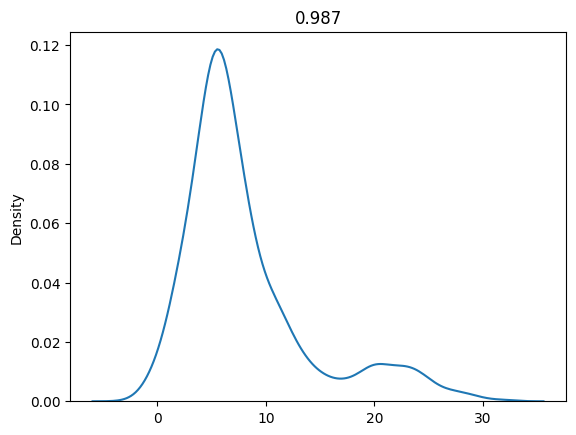

In [62]:
muscle_ind = 0
sns.kdeplot(a_mean_delta[:, 0, muscle_ind])
plt.title((a_mean_delta[:, 0, muscle_ind] > 0).mean())

In [19]:
(a_mean[:, 1, :] - a_mean[:, 0, :]) == 

array([[False, False, False, False, False,  True],
       [False, False, False, False, False,  True],
       [False, False, False, False,  True, False],
       ...,
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

Text(0.5, 1.0, '$\\Pr($ SCI Threshold > Uninjured Threshold $)$ = 0.929')

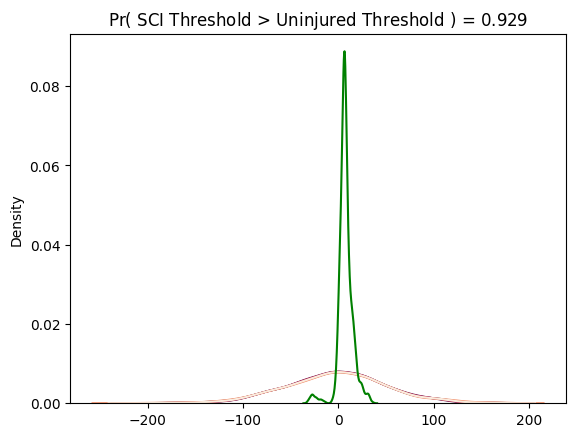

In [14]:
muscle_ind = 5



n_priors_to_plot = 5
prior_palette = sns.color_palette("rocket", as_cmap=True)
prior_colors = iter(prior_palette(np.linspace(0, 1, n_priors_to_plot)))

# d = dist.Uniform(50, 100)
# a_mean_delta_global_scale = d.sample(model.rng_key, sample_shape=(n_priors_to_plot, ))

d = dist.Exponential(1 / 29.)
a_mean_delta_df_minus_one = d.sample(model.rng_key, sample_shape=(n_priors_to_plot, ))

for i in range(n_priors_to_plot):
    color = next(prior_colors)
    d = dist.StudentT(loc=0, scale=50, df=a_mean_delta_df_minus_one[i] + 1)
    samples = d.sample(model.rng_key, sample_shape=(1000, ))
    sns.kdeplot(samples, color=color)

sns.kdeplot(a_mean_delta[:, 0, muscle_ind], color="green", label="Posterior")
plt.title(f"$\Pr($ SCI Threshold > Uninjured Threshold $)$ = {(a_mean_delta[:, 0, muscle_ind] > 0).mean():.3f}")


In [27]:
posterior_samples["a_mean_delta_global_df_minus_one"].mean()

30.056026483803556

In [28]:
posterior_samples["a_mean_delta_global_scale"].mean()


5.090307160604018

In [29]:
posterior_samples["a_mean_delta_global_loc"].mean()


8.127834232201948

In [31]:
a_mean = posterior_samples["a_mean"]
a_mean = np.array(a_mean)
a_mean.shape

(4000, 2, 6)

Text(0.5, 1.0, '0.9295')

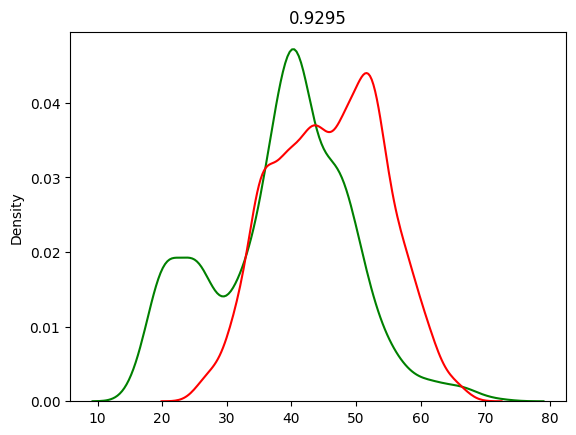

In [38]:
muscle_ind = 5

sns.kdeplot(a_mean[:, 0, muscle_ind], color="green")
sns.kdeplot(a_mean[:, 1, muscle_ind], color="red")
plt.title((a_mean[:, 1, muscle_ind] > a_mean[:, 0, muscle_ind]).mean())

In [ ]:
a_mean_delta_df_minus_one = numpyro.sample("a_mean_delta_df_one", dist.Exponential(1 / 29.))

with numpyro.plate("n_delta", (n_feature0 - n_baseline), dim=-2):
    a_mean_delta = numpyro.sample("a_mean_delta", dist.StudentT(loc=0, scale=100, df=a_mean_delta_df_minus_one + 1))

NameError: name 'a' is not defined